<a href="https://colab.research.google.com/github/Asifbinsyed/Pytorch/blob/main/Transfer_learning_ZTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# let's download all of the modular code from the github repository

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] couldn't find torchinfo ... installing it")
  !pip install -q torchinfo
  from torchinfo import summary

# try to import the going modular directory . if not available then fetch it from github
try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO]: Couldn't find going modular scripts. downloading it from the github " )
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine


[INFO] couldn't find torchinfo ... installing it
[INFO]: Couldn't find going modular scripts. downloading it from the github 
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 40.44 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [3]:
#set up the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Get the data

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# Manual tranform of data for the DataLoader
- we call it manual transform since previous documentation has used that. but it's a good way if you want to change some if the transformation and compare the performance

In [7]:
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)), # reshape all the images to 224 * 224
    transforms.ToTensor(), # turn the image between 0 and 1
    transforms.Normalize(mean= [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [10]:
# creating dataloaders using the going moduler dataengine function
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transform,
                                                                               batch_size = 32,
                                                                               num_workers = 1)
class_names

['pizza', 'steak', 'sushi']

# Auto Transformation


In [11]:
# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# now let's see the magic of getting all the transformation
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transform,
                                                                               batch_size = 32,
                                                                               num_workers = 1)
class_names

['pizza', 'steak', 'sushi']

# Let's create the model

In [15]:
model = torchvision.models.efficientnet_b0(weights = weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


In [20]:
# Now let's examine the origina efficinetv0 structure
summary(model= model,
        input_size= (32,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 15,
        row_settings= ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864             True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64              True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              True
│    │    └─MBConv (0)                              

In [21]:
## Now let's freeze the base models and changing the output layer to suit our needs

for params in model.features.parameters() :
  params.requires_grad = False

In [26]:
# now change the classifier layer
# set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get the length of the output size
output_shape = len(class_names)

# Recreate the classifier layer and seed it into the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p= 0.2, inplace = True),
    torch.nn.Linear (in_features = 1280,
                     out_features = output_shape,
                     bias = True)).to(device)

In [27]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3]         --              Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              False
│    │    └─MBConv (0)                      

# Train the model

In [29]:
# define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

In [31]:
# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timesr
from timeit import default_timer as timer
start_time = timer()

# setup training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5 ,
                       device = device)

# end the timer
end_time = timer()

print(f'[INFO] total training time: {end_time - start_time:.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5359 | train_acc: 0.9375 | test_loss: 0.5666 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.4877 | train_acc: 0.9492 | test_loss: 0.5054 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.4747 | train_acc: 0.9141 | test_loss: 0.4973 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.4789 | train_acc: 0.8398 | test_loss: 0.4756 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.4214 | train_acc: 0.9570 | test_loss: 0.4848 | test_acc: 0.9176
[INFO] total training time: 9.689


# Evaluate the model by loss plotting

In [41]:
# get the plot_loss_curves() function from helper_functions.py

try:
  from helper_functions import plot_loss_curve
except:
  print("[INFO] Couldn't find helper function")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curve


# plot the loss curve of our model
helper_functions.plot_loss_curves(results)

[INFO] Couldn't find helper function


ImportError: cannot import name 'plot_loss_curve' from 'helper_functions' (/content/helper_functions.py)

In [44]:
# get the plot_loss_curves() function from helper_functions.py
import helper_functions

In [47]:
from helper_functions import accuracy_fn

ImportError: cannot import name 'accuracy_fn' from 'helper_functions' (/content/helper_functions.py)

In [46]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

In [48]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

[INFO] Couldn't find helper_functions.py, downloading...


ImportError: cannot import name 'plot_loss_curves' from 'helper_functions' (/content/helper_functions.py)

In [49]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

[INFO] Couldn't find helper_functions.py, downloading...


ImportError: cannot import name 'plot_loss_curves' from 'helper_functions' (/content/helper_functions.py)

In [50]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

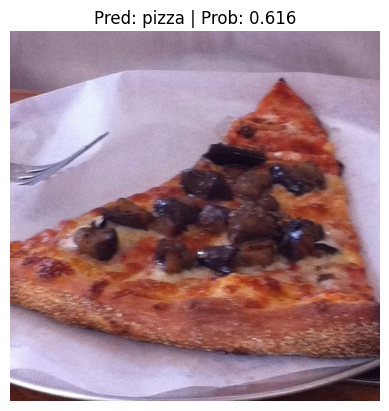

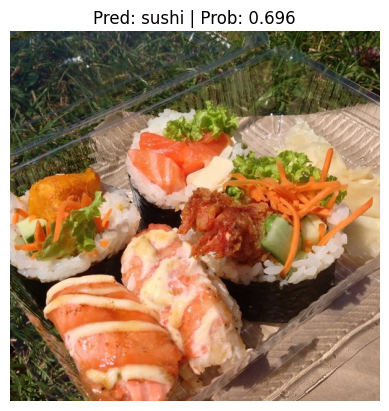

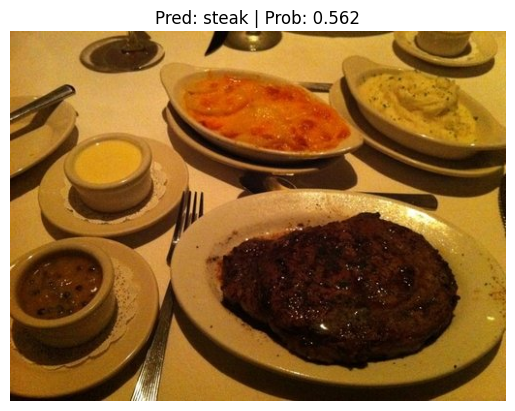

In [51]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

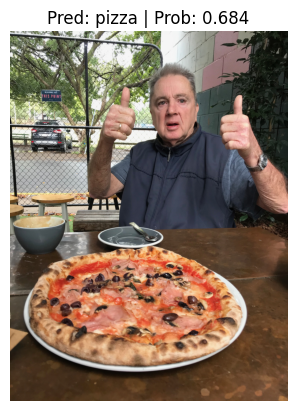

In [52]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)